In [1]:
# %% model and sae loading
import os
os.chdir("../")
from sae.sae_model import SparseAutoencoder
import torch 
import pandas as pd 
from tqdm.auto import tqdm
from skvideo.io import vwrite
from IPython.display import Video
from diffusion_policy.policy.diffusion_transformer_lowdim_policy import DiffusionTransformerLowdimPolicy
from diffusion_policy.model.diffusion.transformer_for_diffusion import TransformerForDiffusion
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import collections
import random
from diffusion_policy.env.pusht.pusht_keypoints_env import PushTKeypointsEnv
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed1_acts = pd.read_csv("data/activations_summary.csv")
seed2_acts = pd.read_csv("data/activations_summary_2.csv")

sae_path = "sae/results_layer4_dim2048_k64_auxk64_dead200/checkpoints/last.ckpt"
sae_weights = torch.load(sae_path)
ckpt = {}
for k in sae_weights['state_dict'].keys():
    if k.startswith('sae_model.'):
        ckpt[k.split(".")[1]] = sae_weights['state_dict'][k]
sae = SparseAutoencoder(256, 2048, 64, 64, 32, 200)
sae.load_state_dict(ckpt)
sae.to(device)

ckpt_path = "/work/pi_hzhang2_umass_edu/jnainani_umass_edu/Interp4Robotics/diffusionInterp/data/experiments/low_dim/pusht/diffusion_policy_transformer/train_2/checkpoints/latest.ckpt"
state_dict = torch.load(ckpt_path, map_location=device)
config = state_dict['cfg']
model_config = config['policy']['model']
model_config = {k: v for k, v in model_config.items() if not k.startswith('_target_')}
model = TransformerForDiffusion(**model_config)
noise_scheduler_config = config['policy']['noise_scheduler']
noise_scheduler = DDPMScheduler(**noise_scheduler_config)
policy_params = {
    'model': model,
    'noise_scheduler': noise_scheduler,
    'horizon': config['policy']['horizon'],
    'obs_dim': config['policy']['obs_dim'],
    'action_dim': config['policy']['action_dim'],
    'n_action_steps': config['policy']['n_action_steps'],
    'n_obs_steps': config['policy']['n_obs_steps'],
    'num_inference_steps': config['policy'].get('num_inference_steps', None),
    'obs_as_cond': config['policy'].get('obs_as_cond', False),
    'pred_action_steps_only': config['policy'].get('pred_action_steps_only', False),
}
policy = DiffusionTransformerLowdimPolicy(**policy_params)
policy.load_state_dict(state_dict['state_dicts']['model'])
policy.to(device)


/tmp/ipykernel_1933799/1865078928.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sae_weights = torch.load(sae_path)
/tmp/ipykernel_1933799/1865078928.py:38: FutureWarn

DiffusionTransformerLowdimPolicy(
  (model): TransformerForDiffusion(
    (input_emb): Linear(in_features=2, out_features=256, bias=True)
    (drop): Dropout(p=0.0, inplace=False)
    (time_emb): SinusoidalPosEmb()
    (cond_obs_emb): Linear(in_features=20, out_features=256, bias=True)
    (encoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): Mish()
      (2): Linear(in_features=1024, out_features=256, bias=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=

In [2]:
# %% helper functions


def theta_tc(obs):
    """
    Calculates the angle between the target block and the current block
    """
    points_to_average = [
    obs[8], obs[1] #, obs[2]
    ]

    # Convert to a NumPy array for easy computation
    points_array = np.array(points_to_average)

    # Compute the average
    mid_pt = np.mean(points_array, axis=0)
    # mid_pt = obs[3]
    low_t = obs[4]
    curr_block_theta = np.arctan2(-(mid_pt[1] - low_t[1]), mid_pt[0] - low_t[0])
    theta_tc = curr_block_theta - np.pi / 4
    return theta_tc, theta_tc * 180 / np.pi, curr_block_theta, curr_block_theta * 180 / np.pi

def dist_tc(obs):
    """
    Calculates the distance between the target block and the current block
    """
    mid_pt_current = obs[3]
    mid_pt_target = [48, 48]
    dist = np.sqrt((mid_pt_current[0] - mid_pt_target[0])**2 + (mid_pt_current[1] - mid_pt_target[1])**2)
    return dist

def Ka(obs):
    """
    Calculates the closest keypoint to agent """
    agent = obs[-1]
    min_dist = np.inf
    min_idx = -1
    for idx, (x, y) in enumerate(obs):
        if idx == 9:
            continue
        else:
            dist = np.sqrt((x - agent[0])**2 + (y - agent[1])**2)
            if dist < min_dist:
                min_dist = dist
                min_idx = idx
    return min_idx

def theta_action(action):
    """
    Calculates the change in angle of the first and last action
    """
    first_angle = np.arctan2(- action[0][1] + action[1][1], action[0][0] - action[1][0])
    last_angle = np.arctan2(- action[-2][1] + action[-1][1], action[-2][0] - action[-1][0])
    change = last_angle - first_angle
    return first_angle, last_angle, change, change * 180 / np.pi

def dist_action(action):
    """
    Calculates the distance between the first and last action
    """
    dist = np.sqrt((action[0][0] - action[-1][0])**2 + (action[0][1] - action[-1][1])**2)
    return dist

def dist_action_mid(action, obs):
    """
    Calculates the average distance between actions and midpoint of target block
    """
    mid_pt_target = obs[3]
    dist = 0
    for idx, (x, y) in enumerate(action):
        dist += np.sqrt((x - mid_pt_target[0])**2 + (y - mid_pt_target[1])**2)
    return dist / len(action)

def dist_action_target(action):
    """
    Calculates the average distance between actions and midpoint of target block
    """
    dist = 0
    for idx, (x, y) in enumerate(action):
        dist += np.sqrt((x - 48)**2 + (y - 48)**2)
    return dist / len(action)

In [3]:
better_acts = pd.read_csv("data/better_activations_summary.csv")
feature_idx = 922 
better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
).head()

,seed,step_idx,timestep,feature_36,feature_37,feature_43,feature_48,feature_60,feature_74,feature_81,...,feature_123,feature_998,feature_353,feature_813,feature_1536,feature_708,feature_2005,feature_1007,feature_815,feature_1687
17096,27242,112,3.0,0.307702,NaN,NaN,NaN,0.074287,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22898,30449,160,1.0,0.083910,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22899,30449,160,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17093,27242,112,6.0,0.125755,NaN,NaN,0.120889,0.173829,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22894,30449,160,5.0,0.117652,0.08486,NaN,0.077789,0.081088,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
2048*50

102400

In [7]:
len(better_acts)

95300

In [4]:
f922_30 = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
)[['seed','step_idx','timestep', f'feature_{feature_idx}']].head(30)

In [5]:
seed, step, timestep, _ = f922_30[['seed', 'step_idx', 'timestep', f'feature_{feature_idx}']].values[0]
# %%
inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
# %%
obs = torch.Tensor(inf_inputs[int(step)][0]['cond_input'])
obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
# %%
points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
print(points1)
# %%
print(theta_tc(points1))
# %%
print(dist_tc(points1))

/tmp/ipykernel_1933799/1431442656.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


[[37.210842 62.80127 ]
 [39.729767 41.35932 ]
 [56.114487 57.294136]
 [44.37665  52.896835]
 [29.787546 64.14371 ]
 [48.689106 59.0212  ]
 [38.1087   48.662895]
 [37.26817  55.73711 ]
 [51.139698 52.359108]
 [52.965385 63.97052 ]]
(0.04967745343909957, 2.846308419018062, 0.8350756, 47.846308419018065)
6.091604768953897


In [13]:
timestep

3.0

In [15]:
inf_inputs[int(step)][int(timestep)].keys()

dict_keys(['timestep', 'trajectory_input', 'cond_input', 'trajectory_output'])

In [16]:
inp_action = torch.Tensor(inf_inputs[int(step)][int(timestep)]['trajectory_input'])
out_action = torch.Tensor(inf_inputs[int(step)][int(timestep)]['trajectory_output'])
print(inp_action.shape, out_action.shape)

torch.Size([1, 10, 2]) torch.Size([1, 10, 2])


In [17]:
for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
    print(f"Seed: {seed}, Step: {step}, Timestep: {timestep}")
    # print(theta_tc(points1))
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    # print(dist_tc(points1))
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    # print(Ka(points2))
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)
    print(f"Theta_tc: {theta_tc_deg}, d_tc: {d_tc}, ClosestK: {ClosestK} \n Delta_theta_act_in: {Delta_theta_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n Delta_dist_act_in: {Delta_dist_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n d_act_curr_in: {d_act_curr_in} d_act_curr_out: {d_act_curr_out} \n d_act_target_in: {d_act_target_in} d_act_target_out: {d_act_target_out}")
    print("\n")

/tmp/ipykernel_1886101/3652908117.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


Seed: 27242.0, Step: 112.0, Timestep: 3.0
Theta_tc: -5.924453607411201, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: 228.07397729338925 Delta_dist_act_out: 8.524491558907302 
 Delta_dist_act_in: 4.612924313909092 Delta_dist_act_out: 8.524491558907302 
 d_act_curr_in: 12.104566669028511 d_act_curr_out: 12.180254695448014 
 d_act_target_in: 15.469839999955132 d_act_target_out: 15.67071618704117


Seed: 30449.0, Step: 160.0, Timestep: 1.0
Theta_tc: -13.120717011274541, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: 2.857662356274125 Delta_dist_act_out: 7.796555249261298 
 Delta_dist_act_in: 8.82078920555269 Delta_dist_act_out: 7.796555249261298 
 d_act_curr_in: 13.831234245375066 d_act_curr_out: 13.755010382304548 
 d_act_target_in: 16.247847524461836 d_act_target_out: 15.868393522531587


Seed: 30449.0, Step: 160.0, Timestep: 0.0
Theta_tc: -13.120717011274541, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: -73.89350802642849 Delta_dist_act_out: 6.813

/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


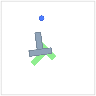

In [21]:
from PIL import Image
env = PushTKeypointsEnv()
env.seed(0)
env.reset()
img = Image.fromarray(env.render(mode='rgb_array'))
display(img)

In [49]:

import gym
from gym import spaces
from PIL import Image
import collections
import numpy as np
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import os
import skimage.transform as st
from diffusion_policy.env.pusht.pymunk_override import DrawOptions
import matplotlib.cm as cm

def get_image_from_obs(points, action, seed, step, timestep, action_mode="Input"):
    center_x, center_y = 96 / 2, 96 / 2
    d_i = 30
    angle = (5 * np.pi) / 4
    end_x = center_x + d_i * np.cos(angle)
    end_y = center_y - d_i * np.sin(angle)
    points_to_average = [
    points[8], points[1] 
    ]
    points_array = np.array(points_to_average)
    average_point = np.mean(points_array, axis=0)

    env = PushTKeypointsEnv()
    canvas = pygame.Surface((env.window_size, env.window_size))
    canvas.fill((255, 255, 255))
    env.screen = canvas
    draw_options = DrawOptions(canvas)
    # Draw goal pose.
    env.space = pymunk.Space()
    goal_body = env._get_goal_pose_body(np.array([256,256,np.pi/4]))
    env.goal_color = pygame.Color('LightGreen')
    block_temp = env.add_tee((256, 300), 0)
    for shape in block_temp.shapes:
        goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
        goal_points += [goal_points[0]]
        pygame.draw.polygon(canvas, env.goal_color, goal_points)
    img = np.transpose(
                    np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
                )
    img = cv2.resize(img, (env.render_size, env.render_size))
    img = Image.fromarray(img)
    plt.imshow(img)
    plt.axis('off')

    # Overlay the points and annotate them
    for idx, (x, y) in enumerate(points):
        if idx == 9:
            plt.scatter(x, y, c='blue', label='Agent start')
        else:
            plt.scatter(x, y, c='red', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
            plt.text(x, y, f'{idx}', fontsize=9, color='blue')

    # Plot arrows for the action trajectory with gradient colors
    num_actions = len(action) - 1
    colors = cm.viridis(np.linspace(0, 1, num_actions)) 
    for i in range(num_actions):
        start_x, start_y = action[i]
        end_x, end_y = action[i + 1]
        dx = end_x - start_x
        dy = end_y - start_y
        if i == 0:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i], label=action_mode+" start")
        elif i == num_actions - 1:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i], label=action_mode+" end")
        else:
            plt.quiver(start_x, start_y, dx, dy, angles='xy', scale_units='xy', scale=1, color=colors[i])

    top_left = points[1]     # Left side of the base
    top_right = points[2]    # Right side of the base
    center_top = points[4]   # Top of the T (center vertical bar)
    mid_point = average_point    # Middle connecting point
    # Draw the base of the T (horizontal line)
    plt.plot([top_left[0], top_right[0]], [top_left[1], top_right[1]], c='grey', linewidth=2)
    # Draw the vertical bar of the T
    plt.plot([mid_point[0], center_top[0]], [mid_point[1], center_top[1]], c='grey', linewidth=2)
    # Plot the center of the image
    plt.scatter(center_x, center_y, c='green', label='Center')  # 
    plt.legend(loc='upper left')
    # plt.title("Points and Line Overlay on Image")
    plt.savefig(f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_action{action_mode}.png")
    plt.close()

# Define a function to compute statistics
def compute_stats(row, policy, save_img=True):
    seed, step, timestep, activation = row.values
    seed, step, timestep = int(seed), int(step), int(timestep)
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt", weights_only=True)
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2) / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2) / 512 * 96
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)

    img_saved = os.path.exists(f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionInput.png")
    if save_img and not img_saved:
        get_image_from_obs(points2, inp_action, seed, step, timestep, "Input")
        get_image_from_obs(points2, out_action, seed, step, timestep, "Output")

    # Collect the results in a dictionary
    return {
        "seed": int(seed),
        "step_idx": int(step),
        "timestep": time_ind,
        "activation": activation,
        "theta_tc_deg": theta_tc_deg,
        "theta_c_deg": theta_c_deg,
        "d_tc": d_tc,
        "ClosestK": ClosestK,
        "Delta_theta_act_in": Delta_theta_act_in,
        "Delta_theta_act_out": Delta_theta_act_out,
        "Delta_dist_act_in": Delta_dist_act_in,
        "Delta_dist_act_out": Delta_dist_act_out,
        "d_act_curr_in": d_act_curr_in,
        "d_act_curr_out": d_act_curr_out,
        "d_act_target_in": d_act_target_in,
        "d_act_target_out": d_act_target_out,
        "img_path_in": f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionInput.png",
        "img_path_out": f"sae_analysis/out/env_imgs/seed{seed}_step{step}_timestep{timestep}_actionOutput.png"
    }

def round_to_significant_digits(val):
    if isinstance(val, (int, float)):  # Check if the value is numeric
        return float(f"{val:.3g}")  # Format to 3 significant digits
    return val  


In [50]:

# Process each selected feature index
for feature_idx in range(1024):
    print(f"Processing feature index: {feature_idx}")
    results = []
    try:
        top_activations = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False).head(20)
    except Exception as e:
        print("Skipping feature ", feature_idx)
        continue
    latent_df = top_activations[['seed', 'step_idx', 'timestep', f'feature_{feature_idx}']]
    non_na_count = better_acts[f"feature_{feature_idx}"].notna().sum()
    if non_na_count < 50:
        print(f"Skipping feature {feature_idx} due to insufficient activations")
        continue
    for idx, row in latent_df.iterrows():
        stats = compute_stats(row, policy)
        results.append(stats)
    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results).sort_values("activation", ascending=False)
    # Reduce precision of numerical values to 3 significant digits
    results_df = results_df.apply(
        lambda col: col.map(round_to_significant_digits) if col.dtype in [np.float64, np.int64] else col
    )
    # Save the DataFrame to a CSV file
    results_df.to_csv(f"sae_analysis/out/new/f{feature_idx}_stats.csv", index=False)
    print(f"Saved CSV for feature index: {feature_idx}")

Processing feature index: 0
Skipping feature  0
Processing feature index: 1
Skipping feature  1
Processing feature index: 2
Skipping feature 2 due to insufficient activations
Processing feature index: 3


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 3
Processing feature index: 4
Skipping feature  4
Processing feature index: 5
Skipping feature 5 due to insufficient activations
Processing feature index: 6
Skipping feature  6
Processing feature index: 7


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 7
Processing feature index: 8
Skipping feature  8
Processing feature index: 9
Skipping feature  9
Processing feature index: 10
Skipping feature  10
Processing feature index: 11
Skipping feature  11
Processing feature index: 12
Skipping feature  12
Processing feature index: 13
Skipping feature  13
Processing feature index: 14
Skipping feature  14
Processing feature index: 15
Skipping feature  15
Processing feature index: 16
Skipping feature  16
Processing feature index: 17
Skipping feature  17
Processing feature index: 18
Skipping feature  18
Processing feature index: 19
Skipping feature  19
Processing feature index: 20
Skipping feature  20
Processing feature index: 21
Skipping feature  21
Processing feature index: 22
Skipping feature  22
Processing feature index: 23
Skipping feature  23
Processing feature index: 24


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 24
Processing feature index: 25
Skipping feature  25
Processing feature index: 26
Skipping feature  26
Processing feature index: 27
Skipping feature  27
Processing feature index: 28


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 28
Processing feature index: 29


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 29
Processing feature index: 30
Skipping feature  30
Processing feature index: 31


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 31
Processing feature index: 32


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 32
Processing feature index: 33
Skipping feature  33
Processing feature index: 34
Skipping feature  34
Processing feature index: 35
Skipping feature  35
Processing feature index: 36


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 36
Processing feature index: 37


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 37
Processing feature index: 38
Skipping feature  38
Processing feature index: 39
Skipping feature  39
Processing feature index: 40
Skipping feature  40
Processing feature index: 41
Skipping feature  41
Processing feature index: 42
Skipping feature  42
Processing feature index: 43


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 43
Processing feature index: 44
Skipping feature  44
Processing feature index: 45
Skipping feature  45
Processing feature index: 46
Skipping feature 46 due to insufficient activations
Processing feature index: 47
Skipping feature  47
Processing feature index: 48


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 48
Processing feature index: 49
Skipping feature  49
Processing feature index: 50
Skipping feature  50
Processing feature index: 51
Skipping feature  51
Processing feature index: 52


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 52
Processing feature index: 53
Skipping feature  53
Processing feature index: 54
Skipping feature  54
Processing feature index: 55


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 55
Processing feature index: 56
Skipping feature  56
Processing feature index: 57
Skipping feature  57
Processing feature index: 58
Skipping feature  58
Processing feature index: 59
Skipping feature  59
Processing feature index: 60


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 60
Processing feature index: 61
Skipping feature  61
Processing feature index: 62
Skipping feature  62
Processing feature index: 63


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 63
Processing feature index: 64
Skipping feature  64
Processing feature index: 65
Skipping feature  65
Processing feature index: 66


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 66
Processing feature index: 67
Skipping feature  67
Processing feature index: 68
Skipping feature  68
Processing feature index: 69
Skipping feature  69
Processing feature index: 70
Skipping feature  70
Processing feature index: 71
Skipping feature  71
Processing feature index: 72
Skipping feature  72
Processing feature index: 73
Skipping feature  73
Processing feature index: 74


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 74
Processing feature index: 75


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 75
Processing feature index: 76
Skipping feature  76
Processing feature index: 77
Skipping feature  77
Processing feature index: 78
Skipping feature  78
Processing feature index: 79


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 79
Processing feature index: 80
Skipping feature  80
Processing feature index: 81


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 81
Processing feature index: 82
Skipping feature  82
Processing feature index: 83
Skipping feature  83
Processing feature index: 84


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 84
Processing feature index: 85
Skipping feature  85
Processing feature index: 86
Skipping feature  86
Processing feature index: 87
Skipping feature  87
Processing feature index: 88
Skipping feature  88
Processing feature index: 89
Skipping feature  89
Processing feature index: 90


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 90
Processing feature index: 91
Skipping feature  91
Processing feature index: 92
Skipping feature  92
Processing feature index: 93


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 93
Processing feature index: 94
Skipping feature  94
Processing feature index: 95
Skipping feature  95
Processing feature index: 96
Skipping feature  96
Processing feature index: 97
Skipping feature  97
Processing feature index: 98


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 98
Processing feature index: 99
Skipping feature  99
Processing feature index: 100
Skipping feature  100
Processing feature index: 101


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 101
Processing feature index: 102
Skipping feature  102
Processing feature index: 103
Skipping feature  103
Processing feature index: 104
Skipping feature  104
Processing feature index: 105


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 105
Processing feature index: 106
Skipping feature  106
Processing feature index: 107


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 107
Processing feature index: 108
Skipping feature  108
Processing feature index: 109
Skipping feature  109
Processing feature index: 110
Skipping feature  110
Processing feature index: 111
Skipping feature  111
Processing feature index: 112


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 112
Processing feature index: 113


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 113
Processing feature index: 114


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 114
Processing feature index: 115


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 115
Processing feature index: 116


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 116
Processing feature index: 117
Skipping feature  117
Processing feature index: 118
Skipping feature  118
Processing feature index: 119


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 119
Processing feature index: 120


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 120
Processing feature index: 121


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 121
Processing feature index: 122
Skipping feature  122
Processing feature index: 123
Skipping feature 123 due to insufficient activations
Processing feature index: 124
Skipping feature  124
Processing feature index: 125


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 125
Processing feature index: 126
Skipping feature  126
Processing feature index: 127


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 127
Processing feature index: 128


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 128
Processing feature index: 129
Skipping feature  129
Processing feature index: 130
Skipping feature  130
Processing feature index: 131
Skipping feature 131 due to insufficient activations
Processing feature index: 132
Skipping feature  132
Processing feature index: 133
Skipping feature  133
Processing feature index: 134


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 134
Processing feature index: 135
Skipping feature 135 due to insufficient activations
Processing feature index: 136


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 136
Processing feature index: 137


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 137
Processing feature index: 138


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 138
Processing feature index: 139
Skipping feature  139
Processing feature index: 140


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 140
Processing feature index: 141
Skipping feature  141
Processing feature index: 142


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 142
Processing feature index: 143
Skipping feature  143
Processing feature index: 144


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 144
Processing feature index: 145
Skipping feature  145
Processing feature index: 146


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 146
Processing feature index: 147
Skipping feature  147
Processing feature index: 148
Skipping feature  148
Processing feature index: 149


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 149
Processing feature index: 150


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 150
Processing feature index: 151


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 151
Processing feature index: 152


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 152
Processing feature index: 153
Skipping feature  153
Processing feature index: 154
Skipping feature  154
Processing feature index: 155


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 155
Processing feature index: 156
Skipping feature  156
Processing feature index: 157
Skipping feature  157
Processing feature index: 158
Skipping feature 158 due to insufficient activations
Processing feature index: 159


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 159
Processing feature index: 160


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 160
Processing feature index: 161
Skipping feature  161
Processing feature index: 162
Skipping feature  162
Processing feature index: 163


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 163
Processing feature index: 164
Skipping feature  164
Processing feature index: 165


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 165
Processing feature index: 166


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 166
Processing feature index: 167


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 167
Processing feature index: 168
Skipping feature  168
Processing feature index: 169


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 169
Processing feature index: 170
Skipping feature  170
Processing feature index: 171


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 171
Processing feature index: 172


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 172
Processing feature index: 173
Skipping feature  173
Processing feature index: 174


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 174
Processing feature index: 175


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 175
Processing feature index: 176


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 176
Processing feature index: 177
Skipping feature  177
Processing feature index: 178


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 178
Processing feature index: 179
Skipping feature  179
Processing feature index: 180
Skipping feature  180
Processing feature index: 181


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 181
Processing feature index: 182


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 182
Processing feature index: 183


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 183
Processing feature index: 184
Skipping feature  184
Processing feature index: 185
Skipping feature  185
Processing feature index: 186


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 186
Processing feature index: 187
Skipping feature  187
Processing feature index: 188
Skipping feature  188
Processing feature index: 189


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 189
Processing feature index: 190
Skipping feature  190
Processing feature index: 191
Skipping feature  191
Processing feature index: 192


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 192
Processing feature index: 193
Skipping feature  193
Processing feature index: 194
Skipping feature  194
Processing feature index: 195
Skipping feature  195
Processing feature index: 196
Skipping feature  196
Processing feature index: 197
Skipping feature  197
Processing feature index: 198
Skipping feature  198
Processing feature index: 199
Skipping feature  199
Processing feature index: 200


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 200
Processing feature index: 201
Skipping feature  201
Processing feature index: 202


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 202
Processing feature index: 203


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 203
Processing feature index: 204


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 204
Processing feature index: 205


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 205
Processing feature index: 206


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 206
Processing feature index: 207


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 207
Processing feature index: 208
Skipping feature  208
Processing feature index: 209
Skipping feature  209
Processing feature index: 210
Skipping feature 210 due to insufficient activations
Processing feature index: 211


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 211
Processing feature index: 212
Skipping feature  212
Processing feature index: 213
Skipping feature  213
Processing feature index: 214


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 214
Processing feature index: 215
Skipping feature 215 due to insufficient activations
Processing feature index: 216


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 216
Processing feature index: 217
Skipping feature  217
Processing feature index: 218
Skipping feature 218 due to insufficient activations
Processing feature index: 219
Skipping feature  219
Processing feature index: 220
Skipping feature  220
Processing feature index: 221
Skipping feature  221
Processing feature index: 222
Skipping feature  222
Processing feature index: 223
Skipping feature  223
Processing feature index: 224
Skipping feature  224
Processing feature index: 225


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 225
Processing feature index: 226
Skipping feature  226
Processing feature index: 227


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 227
Processing feature index: 228
Skipping feature  228
Processing feature index: 229
Skipping feature  229
Processing feature index: 230
Skipping feature  230
Processing feature index: 231
Skipping feature 231 due to insufficient activations
Processing feature index: 232
Skipping feature  232
Processing feature index: 233


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 233
Processing feature index: 234
Skipping feature  234
Processing feature index: 235
Skipping feature  235
Processing feature index: 236
Skipping feature  236
Processing feature index: 237
Skipping feature  237
Processing feature index: 238


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 238
Processing feature index: 239
Skipping feature 239 due to insufficient activations
Processing feature index: 240
Skipping feature  240
Processing feature index: 241


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 241
Processing feature index: 242


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 242
Processing feature index: 243
Skipping feature  243
Processing feature index: 244


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 244
Processing feature index: 245
Skipping feature  245
Processing feature index: 246


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 246
Processing feature index: 247
Skipping feature  247
Processing feature index: 248
Skipping feature  248
Processing feature index: 249


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 249
Processing feature index: 250
Skipping feature  250
Processing feature index: 251


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 251
Processing feature index: 252
Skipping feature  252
Processing feature index: 253
Skipping feature  253
Processing feature index: 254
Skipping feature  254
Processing feature index: 255
Skipping feature  255
Processing feature index: 256
Skipping feature  256
Processing feature index: 257


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 257
Processing feature index: 258
Skipping feature  258
Processing feature index: 259
Skipping feature  259
Processing feature index: 260


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 260
Processing feature index: 261
Skipping feature 261 due to insufficient activations
Processing feature index: 262
Skipping feature  262
Processing feature index: 263
Skipping feature  263
Processing feature index: 264
Skipping feature  264
Processing feature index: 265
Skipping feature  265
Processing feature index: 266


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 266
Processing feature index: 267
Skipping feature  267
Processing feature index: 268
Skipping feature  268
Processing feature index: 269


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 269
Processing feature index: 270


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 270
Processing feature index: 271
Skipping feature  271
Processing feature index: 272
Skipping feature  272
Processing feature index: 273


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 273
Processing feature index: 274
Skipping feature  274
Processing feature index: 275
Skipping feature  275
Processing feature index: 276


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 276
Processing feature index: 277


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 277
Processing feature index: 278


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 278
Processing feature index: 279
Skipping feature 279 due to insufficient activations
Processing feature index: 280


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 280
Processing feature index: 281


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 281
Processing feature index: 282


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 282
Processing feature index: 283
Skipping feature  283
Processing feature index: 284


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 284
Processing feature index: 285
Skipping feature 285 due to insufficient activations
Processing feature index: 286


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 286
Processing feature index: 287


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 287
Processing feature index: 288
Skipping feature  288
Processing feature index: 289
Skipping feature  289
Processing feature index: 290
Skipping feature 290 due to insufficient activations
Processing feature index: 291
Skipping feature  291
Processing feature index: 292


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 292
Processing feature index: 293


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 293
Processing feature index: 294
Skipping feature  294
Processing feature index: 295
Skipping feature  295
Processing feature index: 296


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 296
Processing feature index: 297
Skipping feature  297
Processing feature index: 298
Skipping feature 298 due to insufficient activations
Processing feature index: 299
Skipping feature  299
Processing feature index: 300
Skipping feature  300
Processing feature index: 301
Skipping feature 301 due to insufficient activations
Processing feature index: 302
Skipping feature  302
Processing feature index: 303
Skipping feature  303
Processing feature index: 304
Skipping feature  304
Processing feature index: 305
Skipping feature  305
Processing feature index: 306
Skipping feature  306
Processing feature index: 307


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 307
Processing feature index: 308
Skipping feature  308
Processing feature index: 309
Skipping feature  309
Processing feature index: 310


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 310
Processing feature index: 311
Skipping feature  311
Processing feature index: 312
Skipping feature  312
Processing feature index: 313
Skipping feature  313
Processing feature index: 314
Skipping feature  314
Processing feature index: 315


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 315
Processing feature index: 316
Skipping feature  316
Processing feature index: 317
Skipping feature  317
Processing feature index: 318


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 318
Processing feature index: 319
Skipping feature  319
Processing feature index: 320
Skipping feature  320
Processing feature index: 321


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 321
Processing feature index: 322
Skipping feature  322
Processing feature index: 323


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 323
Processing feature index: 324
Skipping feature  324
Processing feature index: 325
Skipping feature  325
Processing feature index: 326


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 326
Processing feature index: 327
Skipping feature  327
Processing feature index: 328
Skipping feature  328
Processing feature index: 329
Skipping feature  329
Processing feature index: 330


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 330
Processing feature index: 331
Skipping feature  331
Processing feature index: 332
Skipping feature 332 due to insufficient activations
Processing feature index: 333
Skipping feature  333
Processing feature index: 334


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 334
Processing feature index: 335
Skipping feature  335
Processing feature index: 336
Skipping feature  336
Processing feature index: 337


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 337
Processing feature index: 338
Skipping feature  338
Processing feature index: 339


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 339
Processing feature index: 340
Skipping feature  340
Processing feature index: 341
Skipping feature  341
Processing feature index: 342


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 342
Processing feature index: 343
Skipping feature  343
Processing feature index: 344
Skipping feature  344
Processing feature index: 345
Skipping feature  345
Processing feature index: 346


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 346
Processing feature index: 347


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 347
Processing feature index: 348
Skipping feature 348 due to insufficient activations
Processing feature index: 349


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 349
Processing feature index: 350
Skipping feature  350
Processing feature index: 351
Skipping feature  351
Processing feature index: 352


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 352
Processing feature index: 353
Skipping feature 353 due to insufficient activations
Processing feature index: 354


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 354
Processing feature index: 355


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 355
Processing feature index: 356
Skipping feature  356
Processing feature index: 357
Skipping feature  357
Processing feature index: 358


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 358
Processing feature index: 359
Skipping feature  359
Processing feature index: 360
Skipping feature  360
Processing feature index: 361
Skipping feature  361
Processing feature index: 362


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 362
Processing feature index: 363
Skipping feature  363
Processing feature index: 364
Skipping feature 364 due to insufficient activations
Processing feature index: 365


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 365
Processing feature index: 366
Skipping feature  366
Processing feature index: 367
Skipping feature  367
Processing feature index: 368
Skipping feature  368
Processing feature index: 369
Skipping feature  369
Processing feature index: 370


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 370
Processing feature index: 371
Skipping feature  371
Processing feature index: 372


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 372
Processing feature index: 373
Skipping feature 373 due to insufficient activations
Processing feature index: 374
Skipping feature  374
Processing feature index: 375
Skipping feature 375 due to insufficient activations
Processing feature index: 376


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 376
Processing feature index: 377


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 377
Processing feature index: 378


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 378
Processing feature index: 379


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 379
Processing feature index: 380


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 380
Processing feature index: 381
Skipping feature  381
Processing feature index: 382
Skipping feature  382
Processing feature index: 383


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 383
Processing feature index: 384
Skipping feature 384 due to insufficient activations
Processing feature index: 385
Skipping feature  385
Processing feature index: 386


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 386
Processing feature index: 387
Skipping feature  387
Processing feature index: 388


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 388
Processing feature index: 389


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 389
Processing feature index: 390
Skipping feature  390
Processing feature index: 391


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 391
Processing feature index: 392


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 392
Processing feature index: 393
Skipping feature 393 due to insufficient activations
Processing feature index: 394
Skipping feature  394
Processing feature index: 395
Skipping feature 395 due to insufficient activations
Processing feature index: 396
Skipping feature  396
Processing feature index: 397
Skipping feature 397 due to insufficient activations
Processing feature index: 398
Skipping feature  398
Processing feature index: 399


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 399
Processing feature index: 400
Skipping feature  400
Processing feature index: 401
Skipping feature  401
Processing feature index: 402
Skipping feature  402
Processing feature index: 403


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 403
Processing feature index: 404
Skipping feature  404
Processing feature index: 405


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 405
Processing feature index: 406


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 406
Processing feature index: 407
Skipping feature 407 due to insufficient activations
Processing feature index: 408
Skipping feature  408
Processing feature index: 409


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 409
Processing feature index: 410
Skipping feature  410
Processing feature index: 411


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 411
Processing feature index: 412
Skipping feature  412
Processing feature index: 413


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 413
Processing feature index: 414
Skipping feature  414
Processing feature index: 415


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 415
Processing feature index: 416
Skipping feature  416
Processing feature index: 417
Skipping feature  417
Processing feature index: 418
Skipping feature  418
Processing feature index: 419
Skipping feature  419
Processing feature index: 420
Skipping feature  420
Processing feature index: 421
Skipping feature 421 due to insufficient activations
Processing feature index: 422


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 422
Processing feature index: 423


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 423
Processing feature index: 424


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 424
Processing feature index: 425


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 425
Processing feature index: 426
Skipping feature  426
Processing feature index: 427
Skipping feature  427
Processing feature index: 428
Skipping feature 428 due to insufficient activations
Processing feature index: 429
Skipping feature  429
Processing feature index: 430
Skipping feature 430 due to insufficient activations
Processing feature index: 431
Skipping feature 431 due to insufficient activations
Processing feature index: 432
Skipping feature  432
Processing feature index: 433


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 433
Processing feature index: 434
Skipping feature  434
Processing feature index: 435
Skipping feature  435
Processing feature index: 436


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 436
Processing feature index: 437
Skipping feature  437
Processing feature index: 438


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 438
Processing feature index: 439
Skipping feature  439
Processing feature index: 440
Skipping feature  440
Processing feature index: 441
Skipping feature  441
Processing feature index: 442


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


Saved CSV for feature index: 442
Processing feature index: 443
Skipping feature  443
Processing feature index: 444
Skipping feature  444
Processing feature index: 445
Skipping feature  445
Processing feature index: 446
Skipping feature  446
Processing feature index: 447


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


In [46]:
count_features_with_non_na = 0

for feature_idx in range(2048):
    # print(f"Processing feature index: {feature_idx}")
    try:
        # Check the number of non-NA values in the feature column
        non_na_count = better_acts[f"feature_{feature_idx}"].notna().sum()
        
        if non_na_count > 10:
            print(f"Feature index: {feature_idx}, Non-NA count: {non_na_count}")
            count_features_with_non_na += 1
        
    except Exception as e:
        # print("Skipping feature ", feature_idx)
        continue

print(f"Number of features with more than 50 non-NA values: {count_features_with_non_na}")


Feature index: 3, Non-NA count: 3544
Feature index: 7, Non-NA count: 7021
Feature index: 24, Non-NA count: 17544
Feature index: 28, Non-NA count: 47710
Feature index: 29, Non-NA count: 6710
Feature index: 31, Non-NA count: 67513
Feature index: 32, Non-NA count: 9410
Feature index: 36, Non-NA count: 41979
Feature index: 37, Non-NA count: 57584
Feature index: 43, Non-NA count: 35474
Feature index: 48, Non-NA count: 60998
Feature index: 52, Non-NA count: 31319
Feature index: 55, Non-NA count: 15555
Feature index: 60, Non-NA count: 56945
Feature index: 63, Non-NA count: 13894
Feature index: 66, Non-NA count: 3896
Feature index: 74, Non-NA count: 60206
Feature index: 75, Non-NA count: 64757
Feature index: 79, Non-NA count: 16292
Feature index: 81, Non-NA count: 46016
Feature index: 84, Non-NA count: 45516
Feature index: 90, Non-NA count: 31281
Feature index: 93, Non-NA count: 608
Feature index: 98, Non-NA count: 39123
Feature index: 101, Non-NA count: 14618
Feature index: 105, Non-NA count:

In [43]:
30*748

22440

In [44]:
0.5*748/60

6.233333333333333

In [ ]:
# check if a file name exists in a folder
import os
os.path.exists("sae_analysis/out/env_imgs/seed0_step0_timestep0_actionInput.png")


In [21]:
f922_30 = better_acts.sort_values(
    f"feature_{feature_idx}", ascending=False
)[['seed','step_idx','timestep', f'feature_{feature_idx}']].head(5)
for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    seed, step, timestep = int(seed), int(step), int(timestep)
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    obs_norm1 = policy.normalizer['obs'].unnormalize(obs)[0][0]
    obs_norm2 = policy.normalizer['obs'].unnormalize(obs)[0][1]
    inp_action = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
    out_action = np.array(policy.normalizer['action'].unnormalize(action_out)[0].detach().cpu()) / 512 * 96
    points1 = np.array(obs_norm1.detach().cpu()).reshape(-1, 2)  / 512 * 96
    points2 = np.array(obs_norm2.detach().cpu()).reshape(-1, 2)  / 512 * 96
    print(f"Seed: {seed}, Step: {step}, Timestep: {timestep}")
    # print(theta_tc(points1))
    _, theta_tc_deg, _, theta_c_deg = theta_tc(points2)
    # print(dist_tc(points1))
    d_tc = dist_tc(points2)
    ClosestK = Ka(points2)
    # print(Ka(points2))
    _, _, _, Delta_theta_act_in = theta_action(inp_action)
    _, _, _, Delta_theta_act_out = theta_action(out_action)
    Delta_dist_act_in = dist_action(inp_action)
    Delta_dist_act_out = dist_action(out_action)
    # print(dist_action_mid(inp_action, points1))
    d_act_curr_in = dist_action_mid(inp_action, points2)
    d_act_curr_out = dist_action_mid(out_action, points2)
    d_act_target_in = dist_action_target(inp_action)
    d_act_target_out = dist_action_target(out_action)
    print(f"Theta_tc: {theta_tc_deg}, d_tc: {d_tc}, ClosestK: {ClosestK} \n Delta_theta_act_in: {Delta_theta_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n Delta_dist_act_in: {Delta_dist_act_in} Delta_dist_act_out: {Delta_dist_act_out} \n d_act_curr_in: {d_act_curr_in} d_act_curr_out: {d_act_curr_out} \n d_act_target_in: {d_act_target_in} d_act_target_out: {d_act_target_out}")
    get_image_from_obs(points2, inp_action, seed, step, timestep, action_mode="Input")
    get_image_from_obs(points2, out_action, seed, step, timestep, action_mode="Output")
    print("\n")

/tmp/ipykernel_1933799/1231549832.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


Seed: 27242, Step: 112, Timestep: 3
Theta_tc: 4.292908334280913, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: 228.07397729338925 Delta_dist_act_out: 8.524491558907302 
 Delta_dist_act_in: 4.612924313909092 Delta_dist_act_out: 8.524491558907302 
 d_act_curr_in: 12.104566669028511 d_act_curr_out: 12.180254695448014 
 d_act_target_in: 15.469839999955132 d_act_target_out: 15.67071618704117


/work/pi_hzhang2_umass_edu/jnainani_umass_edu/diffusion_policy_interp/diffusion_policy/env/pusht/pymunk_keypoint_manager.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')




Seed: 30449, Step: 160, Timestep: 1
Theta_tc: -2.9033618997715966, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: 2.857662356274125 Delta_dist_act_out: 7.796555249261298 
 Delta_dist_act_in: 8.82078920555269 Delta_dist_act_out: 7.796555249261298 
 d_act_curr_in: 13.831234245375066 d_act_curr_out: 13.755010382304548 
 d_act_target_in: 16.247847524461836 d_act_target_out: 15.868393522531587


Seed: 30449, Step: 160, Timestep: 0
Theta_tc: -2.9033618997715966, d_tc: 6.343284254644151, ClosestK: 2 
 Delta_theta_act_in: -73.89350802642849 Delta_dist_act_out: 6.8138331835571355 
 Delta_dist_act_in: 7.796555249261298 Delta_dist_act_out: 6.8138331835571355 
 d_act_curr_in: 13.755010382304548 d_act_curr_out: 13.503240927422599 
 d_act_target_in: 15.868393522531587 d_act_target_out: 15.520998375859582


Seed: 27242, Step: 112, Timestep: 6
Theta_tc: 4.292908334280913, d_tc: 5.892085507583355, ClosestK: 5 
 Delta_theta_act_in: -37.0210391506273 Delta_dist_act_out: 8.009703604550946 
 

/tmp/ipykernel_1886101/799738041.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")


0.8350756


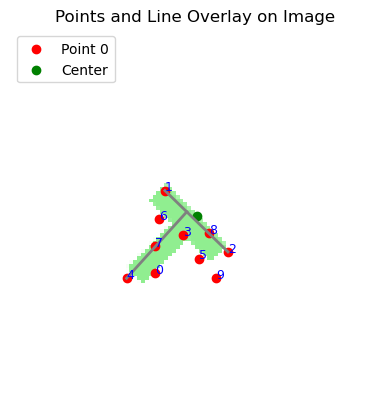

In [96]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Example inputs

for idx, row in f922_30.iterrows():
    seed, step, timestep, _ = row.values
    inf_inputs = torch.load(f"data/inference_inputs_seed_{int(seed)}.pt")
    time_ind = 99 - int(timestep)
    obs = torch.Tensor(inf_inputs[int(step)][time_ind]['cond_input'])
    action_in = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_input'])
    action_out = torch.Tensor(inf_inputs[int(step)][time_ind]['trajectory_output'])
    break
obs = policy.normalizer['obs'].unnormalize(obs)[0][0]  # torch.Size([1, 2, 20])

# Extract the points in (x, y) format
# Reshape the last dimension into 10 pairs of (x, y)
points = np.array(obs.detach().cpu()).reshape(-1, 2)

# Rescale points from [0, 512] to [0, 96]
points = points / 512 * 96
target_action_norm = np.array(policy.normalizer['action'].unnormalize(action_in)[0].detach().cpu()) / 512 * 96
# Center of the image
center_x, center_y = 96 / 2, 96 / 2

# Distance and angle
d_i = 30
angle = (5 * np.pi) / 4  # 45 degrees

# Endpoint of the line
end_x = center_x + d_i * np.cos(angle)
end_y = center_y - d_i * np.sin(angle)  # Subtract because y-coordinates increase downwards in images

_, theta_tc_deg, theta_c_rad, theta_c_deg = theta_tc(points)
print(theta_c_rad)

points_to_average = [
    points[8], points[1] #, points[2]
]

# Convert to a NumPy array for easy computation
points_array = np.array(points_to_average)

# Compute the average
average_point = np.mean(points_array, axis=0)

end_x_curr = average_point[0] + d_i * np.cos(theta_c_rad + np.pi)
end_y_curr = average_point[1] - d_i * np.sin(theta_c_rad + np.pi)  # Subtract because y-coordinates increase downwards in images




env = PushTKeypointsEnv()
# env.reset()
canvas = pygame.Surface((env.window_size, env.window_size))
canvas.fill((255, 255, 255))
env.screen = canvas
draw_options = DrawOptions(canvas)

# Draw goal pose.
env.space = pymunk.Space()
goal_body = env._get_goal_pose_body(np.array([256,256,np.pi/4]))
env.goal_color = pygame.Color('LightGreen')
block_temp = env.add_tee((256, 300), 0) #(average_point[0] / 96 * 512, average_point[1] / 96 * 512), theta_c_rad ) #+ np.pi)
for shape in block_temp.shapes:
    goal_points = [pymunk.pygame_util.to_pygame(goal_body.local_to_world(v), draw_options.surface) for v in shape.get_vertices()]
    goal_points += [goal_points[0]]
    pygame.draw.polygon(canvas, env.goal_color, goal_points)

# env.space.debug_draw (draw_options)
img = np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
img = cv2.resize(img, (env.render_size, env.render_size))
img = Image.fromarray(img)
# display(img)

# Plot the image
image = img  # (96, 96, 3)
plt.imshow(image)
plt.axis('off')

# Overlay the points and annotate them
for idx, (x, y) in enumerate(points):
    plt.scatter(x, y, c='red', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
    plt.text(x, y, f'{idx}', fontsize=9, color='blue')

# for idx, (x, y) in enumerate(target_action_norm):
#     plt.scatter(x, y, c='yellow', label=f'Point {idx}' if idx == 0 else None)  # Points now match image size
#     plt.text(x, y, f'{idx}', fontsize=9, color='red')

# Plot arrows for the action trajectory
# for i in range(len(target_action_norm) - 1):
#     start_x_act, start_y_act = target_action_norm[i]
#     end_x_act, end_y_act = target_action_norm[i + 1]
#     dx = end_x_act - start_x_act
#     dy = end_y_act - start_y_act
#     plt.quiver(start_x_act, start_y_act, dx, dy, angles='xy', scale_units='xy', scale=1, color='purple')

top_left = points[1]     # Left side of the base
top_right = points[2]    # Right side of the base
center_top = points[4]   # Top of the T (center vertical bar)
mid_point = average_point    # Middle connecting point

# Draw the base of the T (horizontal line)
plt.plot([top_left[0], top_right[0]], [top_left[1], top_right[1]], c='grey', linewidth=2)

# Draw the vertical bar of the T
plt.plot([mid_point[0], center_top[0]], [mid_point[1], center_top[1]], c='grey', linewidth=2)

# Plot the center of the T
# plt.scatter(mid_point[0], mid_point[1], c='purple', label='Center', s=100)


# Plot the center of the image
plt.scatter(center_x, center_y, c='green', label='Center')  # Center of the image
# plt.scatter(256/512*96, 300/512*96, c='grey', label='Center')  # Center of the image

# Plot the average point
# plt.scatter(average_point[0], average_point[1], c='orange', label='Average Point')
# plt.scatter(1, 1, c='yellow', label='Action')  # Center of the image

# Draw the line
# plt.plot([center_x, end_x], [center_y, end_y], c='purple', label=f'Line d_i={d_i}, angle=pi/4')
# plt.plot([average_point[0], end_x_curr], [average_point[1], end_y_curr], c='blue', label=f'Line d_i={d_i}, angle=pi/4')
plt.legend(loc='upper left')
plt.title("Points and Line Overlay on Image")
plt.show()

In [60]:
(5 * np.pi) / 4

3.9269908169872414

In [55]:
average_point[0] / 96 * 512, average_point[1] / 96 * 512

(261.30478922526044, 268.466796875)

In [51]:
points[8], points[1], points[2]
# avg of the above points 


(array([51.139698, 52.359108], dtype=float32),
 array([39.729767, 41.35932 ], dtype=float32),
 array([56.114487, 57.294136], dtype=float32))

In [52]:
points_to_average = [
    points[8], points[1], points[2]
]

# Convert to a NumPy array for easy computation
points_array = np.array(points_to_average)

# Compute the average
average_point = np.mean(points_array, axis=0)

print("Average Point:", average_point)

Average Point: [48.994648 50.337524]
